In [2]:
import cube
from astropy.utils import data
from spectral_cube import SpectralCube, Projection
from radio_beam import Beam
from astropy import units as u
import time
import numpy as np
import matplotlib.pyplot as plt
import math
from astropy.io import fits

In [3]:
Dir='/1/home/heh15/workingspace/Arp240/scatter/'
imageDir=Dir+'image/'
logDir=Dir+'log/'

In [4]:
# basic setting
alpha=4.3
ratio=0.77
G=6.67e-11
pc=3.1e16
incl=0.45
beammaj=1.004
beammin=0.556
freq=230.54

In [5]:
name=imageDir+'NGC5257/NGC5257_12CO21_combine_sinbeam_cube.fits'
imagecube=SpectralCube.read(name)
Imcube=imagecube.with_spectral_unit(u.km/u.s,velocity_convention='radio',rest_value=225.46*10**9*u.Hz)

In [6]:
rmscube=cube.calc_noise_in_cube(Imcube)

In [7]:
mask=rmscube<3.0e-3*u.Jy/u.beam
lowrms=rmscube.with_mask(~mask)
newrms=lowrms.with_fill_value(3.0e-3)

In [8]:
outcube=cube.find_signal_in_cube(Imcube,newrms,snr_hi=5)
kcube=outcube.to(u.K)

In [9]:
# surface density
mom0=kcube.moment(order=0)
array=np.array(mom0)
array_inan=np.nan_to_num(array)
mom0_binned=array_inan.reshape(192,5,192,5).mean(-1).mean(1)
SD=alpha/ratio*mom0_binned*incl

# velocity dispersion
mom2=kcube.linewidth_sigma()
mom2_binned=mom2.reshape(192,5,192,5).mean(-1).mean(1)
disp=np.array(mom2_binned)

# scale height
height=disp**2/(SD*math.pi*G)*(1e6/(2e30/pc**2))
Height=height/pc

load the data from the casa made data

In [10]:
data=np.transpose(np.loadtxt(logDir+'Sd_H.txt'))
sd=data[0].astype(np.float)
height=data[1]

In [11]:
fitsfile=imageDir+'NGC5257/sd_casa.fits'
sd=fits.open(fitsfile)[0].data

fitsfile=imageDir+'NGC5257/height_casa.fits'
height=fits.open(fitsfile)[0].data

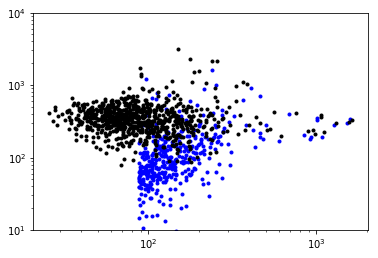

In [12]:
fig=plt.figure()
plt.title('H-sd')
ax=plt.axes(xscale='log',yscale='log')
plt.ylim(10,10000)
plt.scatter(sd,height,marker='.',color='blue')
plt.scatter(SD,Height,marker='.',color='black')

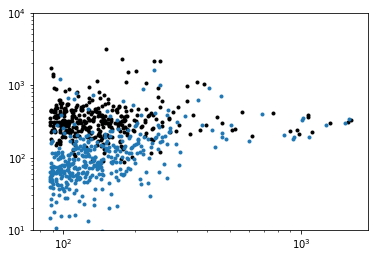

In [13]:
# check the surface densiy less than 5*rms_mom0
rms_mom0=5*0.17*incl
threshold=alpha/ratio*rms_mom0/(0.0109*beammaj*beammin*(freq/115.27)**2)
lowsd=SD<threshold
SD[lowsd]='nan'
Height[lowsd]='nan'

fig=plt.figure()
ax=plt.axes(xscale='log',yscale='log')
plt.ylim(10,10000)
plt.scatter(SD,Height,marker='.',color='black')
plt.scatter(sd,height,marker='.')

In [15]:
np.count_nonzero(~np.isnan(Height))

362

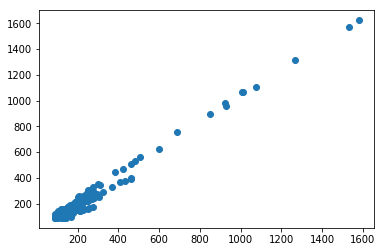

In [16]:
fig=plt.figure()
plt.scatter(sd,SD)

(0, 2000)

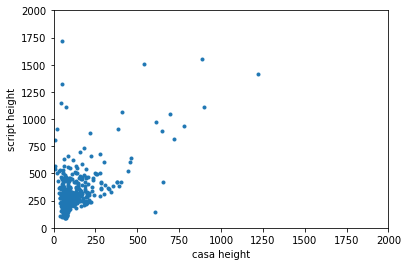

In [17]:
fig=plt.figure()
# ax=plt.axes(xscale='log',yscale='log')
plt.scatter(height,Height,marker='.')
plt.xlabel('casa height')
plt.ylabel('script height')
plt.xlim(0,2000)
plt.ylim(0,2000)

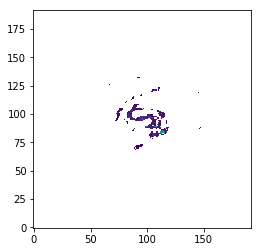

In [18]:
fig=plt.figure()
plt.imshow(height,origin='lower')

In [19]:
outputfits=imageDir+'NGC5257/height_script.fits'
hdul=fits.open(imageDir+'NGC5257/NGC5257_12CO21_pbcor_rebin_mom0.fits')
hdul[0].data=Height
hdul.writeto(outputfits)
hdul.close()

OSError: File '/1/home/heh15/workingspace/Arp240/scatter/image/NGC5257/height_script.fits' already exists.

In [1]:
outputfits=imageDir+'NGC5257/height_casa2.fits'
hdul=fits.open(imageDir+'NGC5257/NGC5257_12CO21_pbcor_rebin_mom0.fits')
hdul[0].data=height
hdul.writeto(outputfits)
hdul.close()

NameError: name 'imageDir' is not defined